In [1]:
!pip install diffusers["torch"] transformers # install transformers
!pip install accelerate
# install diffusers from source
!pip install git+https://github.com/huggingface/diffusers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 24.1 MB/s eta 0:00:00
  Cloning https://github.com/huggingface/diffusers to /tmp/pip-req-build-wegpqn4_
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/diffusers /tmp/pip-req-build-wegpqn4_
  Resolved https://github.com/huggingface/diffusers to commit 8cdcdd9e32925200ce5e1cf410fe14a774f3c3a6
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for diffusers: filename=diffusers-0.31.0.dev0-py3-none-any.whl size=2723926 sha256=1ee2475c703d8f7640d0f4940002212dbe05ff85971a1272d48b8e3fd2f669b5
  Stored in directory: /tmp/pip-ephem-wheel-cache-8786bn8n/wheels/f7/7d/99/d361489e5762e3464b3811bc629e94cf5bf5ef44dd5c3c4d52
Successfully built diffusers
  Attempting uninstall: diffusers
    Found existing installation: diffusers 0.30.2
    Uninstalling diffusers-0.30.2:
      Successfully uninstalled diffusers-

# Basic pipeline

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

scheduler_config.json:   0%|          | 0.00/256 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/790 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/455M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

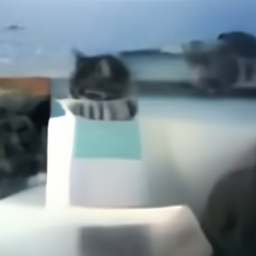

In [2]:
from diffusers import DDPMPipeline

ddpm = DDPMPipeline.from_pretrained("google/ddpm-cat-256", use_safetensors=True).to("cuda") # Unet2D model & DDPM scheduler.
image = ddpm(num_inference_steps=25).images[0]
image

<p align="center">
 <img src = "./figs/DDPM.png", height="256">
</p>

Pipeline = model + scheduler

## 1. Load model and scheduler

In [3]:
from diffusers import DDPMScheduler, UNet2DModel

scheduler = DDPMScheduler.from_pretrained("google/ddpm-cat-256")
model = UNet2DModel.from_pretrained("google/ddpm-cat-256", use_safetensors=True).to("cuda")

## 2. Set the number of timesteps to run the denoising process for:

In [4]:
scheduler.set_timesteps(50)

In [5]:
print(scheduler.timesteps)

tensor([980, 960, 940, 920, 900, 880, 860, 840, 820, 800, 780, 760, 740, 720,
        700, 680, 660, 640, 620, 600, 580, 560, 540, 520, 500, 480, 460, 440,
        420, 400, 380, 360, 340, 320, 300, 280, 260, 240, 220, 200, 180, 160,
        140, 120, 100,  80,  60,  40,  20,   0])


## 3. Create some random noise with the same shape as the desired output:

In [6]:
import torch

sample_size = model.config.sample_size
noise = torch.randn((1, 3, sample_size, sample_size), device="cuda")

## 4. Denoising steps

In [7]:
input = noise

for t in scheduler.timesteps:
    with torch.no_grad():
        noisy_residual = model(input, t).sample
    previous_noisy_sample = scheduler.step(noisy_residual, t, input).prev_sample
    input = previous_noisy_sample


## 5. Denoised output

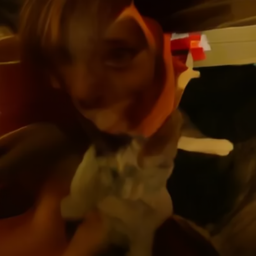

In [8]:
from PIL import Image
import numpy as np

image = (input / 2 + 0.5).clamp(0, 1).squeeze()
image = (image.permute(1, 2, 0) * 255).round().to(torch.uint8).cpu().numpy()
image = Image.fromarray(image)
image